In [56]:
from langchain_community.document_loaders import PyPDFLoader
from IPython.display import Markdown
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain import hub
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI

In [57]:
load_dotenv()

True

In [58]:
pdf_1 = PyPDFLoader("./data/falcon/falcon-users-guide-2021-09.pdf") \
    .load()

Markdown(
    pdf_1 \
    [0] \
    .page_content
)

Overwriting cache for 0 11250


 
© Space Exploration Technologies Corp.  All rights reserved.  
  
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
COPYRIGHT  
Subject to the existing rights of third parties, Space Exploration Technologies Corp. (SpaceX) is the owner of the copyright 
in this work, and no portion hereof is to be copied, reproduced, or disseminated without the prior written consent of 
SpaceX.  


In [59]:
pdf_2 = PyPDFLoader("./data/falcon/Capabilities&Services.pdf") \
    .load()

Markdown(
    pdf_2 \
    [0] \
    .page_content
)


CAPABILITIES & SERVICESFALCON 9DESTINATIONSpaceX offers competitive pricing for its Falcon 9 and Falcon Heavy launch services. SpaceXalso offers crew transportation services tolow-Earth orbit (LEO) destinations.See additional information at spacex.com/humanspaceflight.
LOW-EARTH ORBIT (LEO)GEOSYNCHRONOUS TRANSFER ORBIT (GTO)PAYLOAD TO MARS22,000 kg50,265 lbs8,300 kg18,300 lbs4,020 kg8,860 lbsSTANDARD PAYMENT PLAN(through 2024)$69.75 MUp to 5.5 mT TO GTOPRICE *
*Pricing adjustments made in January 2024 account for inflation. Missions purchased in 2024 but flown beyond 2027 may be subject to additional adjustments due to inflation.Performance represents max capability on fully expendable vehicle.


In [65]:
docs = pdf_1 + pdf_2

print(len(docs))

89


In [66]:
# define helper function to format multiple docs in one text
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

## 1. How tables are difficult for RAG 💢


Note to trainer:
- Set environment variables in `.env`:

    ```
    LANGCHAIN_TRACING_V2=true
    LANGCHAIN_ENDPOINT
    LANGCHAIN_API_KEY="https://api.smith.langchain.com"
    LANGCHAIN_PROJECT="Advanced LLM's"
    ```

- Show interactively section **1**, then let participants do section **2**.

### Falcon 9 rocket example


In [67]:
llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0,
    top_p=0.0001,
    seed=42,
)
embedding = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

/Users/dunnkers/.pyenv/versions/levels-of-rag/lib/python3.11/site-packages/langchain_core/utils/utils.py:161: UserWarning: WARNING! top_p is not default parameter.
                top_p was transferred to model_kwargs.
                Please confirm that top_p is what you intended.
  warnings.warn(
/Users/dunnkers/.pyenv/versions/levels-of-rag/lib/python3.11/site-packages/langchain_core/utils/utils.py:161: UserWarning: WARNING! seed is not default parameter.
                seed was transferred to model_kwargs.
                Please confirm that seed is what you intended.
  warnings.warn(


In [68]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

In [69]:
# uncomment to re-create vectors and vectorstore
vectorstore = FAISS.from_documents(splits, embedding=embedding)

In [23]:
# vectorstore = FAISS.load_local("data/falcon_vectorstore.faiss", embeddings=embedding, allow_dangerous_deserialization=True)

In [70]:
retriever = vectorstore.as_retriever()

In [25]:
# uncomment to save the vectorstore
# vectorstore.save_local("data/falcon_vectorstore.faiss")

In [71]:
retriever.invoke(
    "standard payment plan"
)

[Document(page_content='© Space Exploration Technologies Corp.  All rights reserved.  5 \n \n \nThe standard pric e for Falcon  9 and Falcon Heavy launch services can be found at  \nhttps://www.spacex.com/media/Capabilities&Services.pdf . Pricing includes range services, standard payload \nintegration an d third -party liability insurance. Please see Section 7.3 for a complete description of standard services . \nNonstandard services  are also available.', metadata={'source': './data/falcon/falcon-users-guide-2021-09.pdf', 'page': 8}),
 Document(page_content='Contracting  ................................ ................................ ................................ ................................ ................................ .........  52 \n Mission Management  ................................ ................................ ................................ ................................ ......................  52 \n Standard Services  ................................ .....

In [72]:
prompt = hub.pull("rlm/rag-prompt")

In [73]:
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [74]:
retriever.invoke(
    "whats the price for a falcon 9 rocket?"
)

[Document(page_content='© Space Exploration Technologies Corp.  All rights reserved.  5 \n \n \nThe standard pric e for Falcon  9 and Falcon Heavy launch services can be found at  \nhttps://www.spacex.com/media/Capabilities&Services.pdf . Pricing includes range services, standard payload \nintegration an d third -party liability insurance. Please see Section 7.3 for a complete description of standard services . \nNonstandard services  are also available.', metadata={'source': './data/falcon/falcon-users-guide-2021-09.pdf', 'page': 8}),
 Document(page_content='CAPABILITIES & SERVICESFALCON 9DESTINATIONSpaceX offers competitive pricing for its Falcon 9 and Falcon Heavy launch services. SpaceXalso offers crew transportation services tolow-Earth orbit (LEO) destinations.See additional information at spacex.com/humanspaceflight.\nLOW-EARTH ORBIT (LEO)GEOSYNCHRONOUS TRANSFER ORBIT (GTO)PAYLOAD TO MARS22,000 kg50,265 lbs8,300 kg18,300 lbs4,020 kg8,860 lbsSTANDARD PAYMENT PLAN(through 2024)$69

In [75]:
Markdown(
    rag_chain.invoke(
        "whats the price for a falcon 9 rocket?"
    )
)

The price for a Falcon 9 rocket is $69.75 million according to the standard payment plan through 2024. This pricing includes range services, standard payload integration, and third-party liability insurance. Additional information can be found on the SpaceX website.

In [31]:
retriever.invoke(
    "whats the price for a falcon 9 rocket with the standard payment plan?"
)

[Document(page_content='© Space Exploration Technologies Corp.  All rights reserved.  5 \n \n \nThe standard pric e for Falcon  9 and Falcon Heavy launch services can be found at  \nhttps://www.spacex.com/media/Capabilities&Services.pdf . Pricing includes range services, standard payload \nintegration an d third -party liability insurance. Please see Section 7.3 for a complete description of standard services . \nNonstandard services  are also available.', metadata={'source': './data/falcon/falcon-users-guide-2021-09.pdf', 'page': 8}),
 Document(page_content='CAPABILITIES & SERVICESFALCON 9DESTINATIONSpaceX offers competitive pricing for its Falcon 9 and Falcon Heavy launch services. SpaceXalso offers crew transportation services tolow-Earth orbit (LEO) destinations.See additional information at spacex.com/humanspaceflight.\nLOW-EARTH ORBIT (LEO)GEOSYNCHRONOUS TRANSFER ORBIT (GTO)PAYLOAD TO MARS22,000 kg50,265 lbs8,300 kg18,300 lbs4,020 kg8,860 lbsSTANDARD PAYMENT PLAN(through 2024)$69

In [76]:
Markdown(
    rag_chain.invoke(
        "whats the price for a falcon 9 rocket launch with the standard payment plan?"
    )
)

The price for a Falcon 9 rocket launch with the standard payment plan is $69.75 million through 2024. This pricing includes range services, standard payload integration, and third-party liability insurance. Additional information can be found at spacex.com/humanspaceflight.

In [77]:
retriever.invoke(
    "what is the payload I carry with the Falcon 9 rocket to Mars?"
)

[Document(page_content='© Space Exploration Technologies Corp.  All rights reserved.  72 \n Table 7 -3: Additional required documents and data for non -US persons and n on-US government \npayloads  ................................ ................................ ................................ ................................ ...........................  55 \nTable 8 -1: Services and equipment for payload processing  ................................ ................................ .. 58 \nTable 8 -2: Launch control organization  ................................ ................................ ................................ ..... 61 \nTable 8 -3: Falcon 9 sample flight timeline —GTO mission  ................................ ................................ ..... 66 \nTable 8 -4: Falcon 9 sample flight timeline —LEO mission  ................................ ................................ ...... 66', metadata={'source': './data/falcon/falcon-users-guide-2021-09.pdf', 'page': 75}),

In [79]:
Markdown(
    rag_chain.invoke(
        "what is the payload I can carry with the Falcon 9 rocket to Mars?"
    )
)

The payload capacity of the Falcon 9 rocket to Mars is 8,300 kg or 18,300 lbs. SpaceX offers competitive pricing for its launch services to various destinations, including low-Earth orbit and Mars. Customers need to verify the mass properties of their payload before shipping it to the launch site.

### Budgeting example


In [80]:
pdf_budget = PyPDFLoader("./data/annual_budget/Begroting 2024 NPO tabellen.pdf") \
    .load()
len(pdf_budget)

3

Let's inspect how the PDF was parsed.

In [82]:
Markdown(pdf_budget[0].page_content)

NPO Begroting 2024 10
Budgetaanvraag
De publieke omroep vraagt in totaal een budget aan van 966 miljoen euro voor 2024.  
In deze begroting wordt daar waar mogelijk vergeleken met de prognose van de beschik -
bare middelen voor 2023. Deze prognose is gebaseerd op het gewijzigde en vastgestelde 
OCW-budget 2023 en gaat uit van de geplaatste en toegekende programma’s,  
reserveringen en de verdeling van de (extra) prijsbijstelling per juni 2023. 
Conform de Mediawet ontvangt de publieke omroep compensatie voor kostenstijgingen 
door indexatie van het Rijksmediabijdragedeel van het minimumbudget. Dat is het totale 
bedrag exclusief Ster-inkomsten waarover geen index geldt. Voor 2024 is daarbij uitgegaan 
van een consumentenprijsindex (CPI) van 3,1%. Daarnaast voorziet de Mediawet in een 
verhoging van het budget met een index die de groei van het aantal huishoudens   
representeert. Dit laatste leidt tot een aanvullend bedrag voor 2024 ten opzichte van  
2023 van 3,7 miljoen euro. In het vastgestelde budget 2023 is een (extra) prijsbijstelling 
toegepast. 
Het totale OCW-budget dat de publieke omroep aanvraagt komt daarmee uit op een 
bedrag van afgerond 966 miljoen euro, waarvan 829,3 miljoen euro programmabudget. 
Het programmabudget is inclusief het budget voor het Coproductiefonds Binnenlandse 
Omroep (CoBO) van 8,2 miljoen euro. Het aangevraagde OCW-budget voor 2024 bevat 
daarnaast een bedrag van 1,15 miljoen euro ten behoeve van de toe  gezegde extra middelen 
voor audio  descriptie (NPO).
Bijlage B maakt zichtbaar hoe het totale programmabudget van 829,3 miljoen euro is 
onderverdeeld naar het (wettelijke) garantiebudget van de omroepen. Zoals gebruikelijk 
vraagt de NPO ook het budget aan voor de Stichting Omroep Muziek (SOM). De aanvraag 
voor komend jaar voor de SOM bedraagt 22.738.000 euro. Dat bedrag houdt nog geen 
rekening met een indexering. De toelichting op deze budgetaanvraag stuurt de SOM 
separaat aan OCW toe. Nevenstaande tabel geeft de begrote beschikbare middelen 2024 
per onderdeel weer en vergelijkt die op totaalniveau met de prognose voor 2023.Tabel 1. Budgetaanvraag 2024 (in €)
ArtikelBudgetaanvraag 
20241Prognose 
20232
2.149, lid 1, sub c NOS 158.456.648 171.609.317
2.149, lid 1, sub a Omroepverenigingen met erkenning 249.276.395 241.707.119
2.149, lid 1, sub b Omroepverenigingen met voorlopige erkenning 8.309.213 8.056.904
2.149, lid 1, sub d NTR 61.407.904 59.543.254
Totaal zendgemachtigden 477.450.160 480.916.594
2.149, lid 1, sub f Programmaversterking 351.813.269 348.829.407
Totaal programmabudget 829.263.429 829.746.001
2.149, lid 1, sub e NPO 134.979.571 131.074.000
2.149, lid 1, sub e Stichting BVN 1.779.000 1.749.000
Totaal OCW -budget 966.022.000 962.569.001
1 Inclusief 18 miljoen eur o ten behoeve van meerkosten superevenementen in 2024
2  Exclusief 5 miljoen euro uit de AMr ten behoeve van meerkosten superevenementen in 2023, exclusief  
5,0 miljoen euro ten behoeve van het cultuurplan en inclusief 43,5 miljoen ten behoeve van meerkosten 
toekomstige superevenementen NPO Begroting 2024 Uitwerking 2024 Concessiebeleidsplan 2022 -2026 Budgetaanvraag 2024 Bijlagen

... which comes from this page in the PDF:

![alt text](<./data/annual_budget/Screenshot 2024-09-12 at 10.40.17.png>)

In [83]:
llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0,
    top_p=0.0001,
    seed=42,
)
embedding = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

/Users/dunnkers/.pyenv/versions/levels-of-rag/lib/python3.11/site-packages/langchain_core/utils/utils.py:161: UserWarning: WARNING! top_p is not default parameter.
                top_p was transferred to model_kwargs.
                Please confirm that top_p is what you intended.
  warnings.warn(
/Users/dunnkers/.pyenv/versions/levels-of-rag/lib/python3.11/site-packages/langchain_core/utils/utils.py:161: UserWarning: WARNING! seed is not default parameter.
                seed was transferred to model_kwargs.
                Please confirm that seed is what you intended.
  warnings.warn(


In [84]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000)
splits = text_splitter.split_documents(pdf_budget)
vectorstore = FAISS.from_documents(splits, embedding=embedding)
retriever = vectorstore.as_retriever()
prompt = hub.pull("rlm/rag-prompt")
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [85]:
splits

[Document(page_content='NPO Begroting 2024 10\nBudgetaanvraag\nDe publieke omroep vraagt in totaal een budget aan van 966 miljoen euro voor 2024.  \nIn deze begroting wordt daar waar mogelijk vergeleken met de prognose van de beschik -\nbare middelen voor 2023. Deze prognose is gebaseerd op het gewijzigde en vastgestelde \nOCW-budget 2023 en gaat uit van de geplaatste en toegekende programma’s,  \nreserveringen en de verdeling van de (extra) prijsbijstelling per juni 2023. \nConform de Mediawet ontvangt de publieke omroep compensatie voor kostenstijgingen \ndoor indexatie van het Rijksmediabijdragedeel van het minimumbudget. Dat is het totale \nbedrag exclusief Ster-inkomsten waarover geen index geldt. Voor 2024 is daarbij uitgegaan \nvan een consumentenprijsindex (CPI) van 3,1%. Daarnaast voorziet de Mediawet in een \nverhoging van het budget met een index die de groei van het aantal huishoudens   \nrepresenteert. Dit laatste leidt tot een aanvullend bedrag voor 2024 ten opzichte van'

Let's inspect the way we chunked the text:

![alt text](<./data/annual_budget/Screenshot 2024-09-12 at 10.48.57.png>)

<small>See <a href="https://chunkviz.up.railway.app">https://chunkviz.up.railway.app</a>.</small>

Time to ask some questions! Let's test out our simple RAG system.

In [86]:
Markdown(
    rag_chain.invoke(
        "wat is de budget aanvraag van de NTR in 2024?"
    )
)

De budgetaanvraag van de NTR in 2024 bedraagt in totaal 966 miljoen euro. Dit bedrag omvat 829,3 miljoen euro aan programmabudget. Daarnaast is er een bedrag van 1,15 miljoen euro aangevraagd voor extra middelen voor audio-descriptie.

That answer is wildly wrong! The actual value is € 61,407,904. 

![alt text](<./data/annual_budget/Screenshot 2024-09-13 at 10.20.27.png>)

Why did we get it so wrong?

That is, because our table was passed as jumbled text to the LLM:

```
Tabel 1. Budgetaanvraag 2024 (in €) ArtikelBudgetaanvraag 20241Prognose 20232 2.149, lid 1, sub c NOS 158.456.648 171.609.317 2.149, lid 1, sub a Omroepverenigingen met erkenning 249.276.395 241.707.119 2.149, lid 1, sub b Omroepverenigingen met voorlopige erkenning 8.309.213 8.056.904 2.149, lid 1, sub d NTR 61.407.904 59.543.254 Totaal zendgemachtigden 477.450.160 480.916.594 2.149, lid 1, sub f Programmaversterking 351.813.269 348.829.407 Totaal programmabudget 829.263.429 829.746.001 2.149, lid 1, sub e NPO 134.979.571 131.074.000 2.149, lid 1, sub e Stichting BVN 1.779.000 1.749.000 Totaal OCW -budget 966.022.000 962.569.001
```

In [87]:
Markdown(
    rag_chain.invoke(
        "wat is de budget aanvraag totaal zendgemachtigden in 2024?"
    )
)

De publieke omroep vraagt in totaal een budget aan van 966 miljoen euro voor 2024, inclusief 18 miljoen euro voor meerkosten superevenementen. De bijdragen van OCW stijgen met 36,8 miljoen euro, waarvan 28,4 miljoen euro door indexatie. In 2024 wordt 18,0 miljoen euro aangevraagd voor meerkosten Superevenementen.

## 2. Decomposing the table

With a multimodal model.

In [88]:
llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0,
    top_p=0.0001,
    seed=42,
)

/Users/dunnkers/.pyenv/versions/levels-of-rag/lib/python3.11/site-packages/langchain_core/utils/utils.py:161: UserWarning: WARNING! top_p is not default parameter.
                top_p was transferred to model_kwargs.
                Please confirm that top_p is what you intended.
  warnings.warn(
/Users/dunnkers/.pyenv/versions/levels-of-rag/lib/python3.11/site-packages/langchain_core/utils/utils.py:161: UserWarning: WARNING! seed is not default parameter.
                seed was transferred to model_kwargs.
                Please confirm that seed is what you intended.
  warnings.warn(


In [89]:
PROJECT_ID = "academy-advanced-llm-ing-apr25"
LOCATION = "europe-west4"

# Initialize Vertex AI
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [90]:
from vertexai.generative_models import GenerationConfig, GenerativeModel, Image, Part

In [91]:
multimodal_model = GenerativeModel("gemini-2.0-flash")

In [92]:
import http.client
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def display_content_as_image(content: str | Image | Part) -> bool:
    if not isinstance(content, Image):
        return False
    display_images([content])
    return True


def display_content_as_video(content: str | Image | Part) -> bool:
    if not isinstance(content, Part):
        return False
    part = typing.cast(Part, content)
    file_path = part.file_data.file_uri.removeprefix("gs://")
    video_url = f"https://storage.googleapis.com/{file_path}"
    IPython.display.display(IPython.display.Video(video_url, width=600))
    return True


def print_multimodal_prompt(contents: list[str | Image | Part]):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if display_content_as_image(content):
            continue
        if display_content_as_video(content):
            continue
        print(content)

# ref: https://github.com/GoogleCloudPlatform/generative-ai/blob/307d39295ff2c0bfd8fac52a61dcd00f6c3655cc/gemini/use-cases/intro_multimodal_use_cases.ipynb

-------Prompt--------
Instructions: Consider an image extracted from a PDF below:


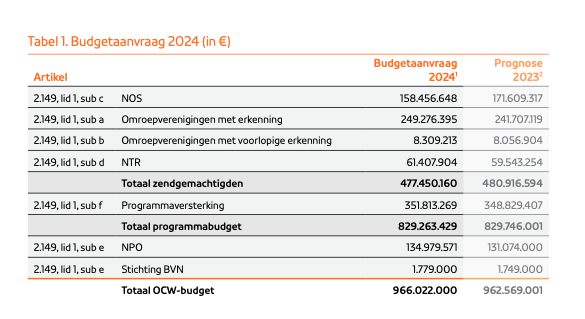


Find tables in the image. For every table, do the following.
Explain every cell of the table above in a bullet-point list. Each element of the list 
should describe what that value (text or number) is about, considering its headers. 
Continue this list redundantly for every cell in this list. Do not explain cells of headers. 
Consider only the values. Answer in the same language that the PDF content was written in.

Example:
- The interest rate of Federal funds (effective) for the week ending on April 15, 2002 was 1.84.
Example:
- The interest rate of Nonfinancial commercial paper for 1-month for the week ending on April 15, 2002 was 1.76.
Example:
- The interest rate of Financial commercial paper for 2-month for the week ending on April 16, 2002 was 1.80.

Facts:
- 


-------Response--------
Hier is de uitleg van elke cel in de tabel:

*   De budgetaanvraag voor NOS in 2024 is 158.456.648.
*   De prognose voor NOS in 2023 is 171.609.317.
*   De budgetaanvraag voor Omroepverenigingen 

In [93]:
from pathlib import Path


image_table = Image.from_bytes(
    Path("./data/annual_budget/Screenshot 2024-09-13 at 10.20.27.png").read_bytes()
)

instructions = "Instructions: Consider an image extracted from a PDF below:"
prompt1 = """
Find tables in the image. For every table, do the following.
Explain every cell of the table above in a bullet-point list. Each element of the list 
should describe what that value (text or number) is about, considering its headers. 
Continue this list redundantly for every cell in this list. Do not explain cells of headers. 
Consider only the values. Answer in the same language that the PDF content was written in.

Example:
- The interest rate of Federal funds (effective) for the week ending on April 15, 2002 was 1.84.
Example:
- The interest rate of Nonfinancial commercial paper for 1-month for the week ending on April 15, 2002 was 1.76.
Example:
- The interest rate of Financial commercial paper for 2-month for the week ending on April 16, 2002 was 1.80.

Facts:
- 
"""


contents = [
    instructions,
    image_table,
    prompt1,
]

responses = multimodal_model.generate_content(contents, stream=True)
response_chunks = []

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")
    response_chunks.append(response.text)

response_str = "".join(response_chunks)

### Testing out querying using facts

In [94]:
facts = response_str.split("\n")
facts = [fact.replace("- ", "", 1) for fact in facts]
facts

['Hier is de uitleg van elke cel in de tabel:',
 '',
 '*   De budgetaanvraag voor NOS in 2024 is 158.456.648.',
 '*   De prognose voor NOS in 2023 is 171.609.317.',
 '*   De budgetaanvraag voor Omroepverenigingen met erkenning in 2024 is 249.276.395.',
 '*   De prognose voor Omroepverenigingen met erkenning in 2023 is 241.707.119.',
 '*   De budgetaanvraag voor Omroepverenigingen met voorlopige erkenning in 2024 is 8.309.213.',
 '*   De prognose voor Omroepverenigingen met voorlopige erkenning in 2023 is 8.056.904.',
 '*   De budgetaanvraag voor NTR in 2024 is 61.407.904.',
 '*   De prognose voor NTR in 2023 is 59.543.254.',
 '*   De totale budgetaanvraag voor zendgemachtigden in 2024 is 477.450.160.',
 '*   De totale prognose voor zendgemachtigden in 2023 is 480.916.594.',
 '*   De budgetaanvraag voor Programmaversterking in 2024 is 351.813.269.',
 '*   De prognose voor Programmaversterking in 2023 is 348.829.407.',
 '*   De totale budgetaanvraag voor programmabudget in 2024 is 829.26

In [95]:
facts_docs = [Document(fact) for fact in facts]

In [96]:
llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0,
    top_p=0.0001,
    seed=42,
)
embedding = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

/Users/dunnkers/.pyenv/versions/levels-of-rag/lib/python3.11/site-packages/langchain_core/utils/utils.py:161: UserWarning: WARNING! top_p is not default parameter.
                top_p was transferred to model_kwargs.
                Please confirm that top_p is what you intended.
  warnings.warn(
/Users/dunnkers/.pyenv/versions/levels-of-rag/lib/python3.11/site-packages/langchain_core/utils/utils.py:161: UserWarning: WARNING! seed is not default parameter.
                seed was transferred to model_kwargs.
                Please confirm that seed is what you intended.
  warnings.warn(


In [97]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000)
splits = text_splitter.split_documents(pdf_budget)
docs = splits + facts_docs

In [99]:
vectorstore = FAISS.from_documents(docs, embedding=embedding)
retriever = vectorstore.as_retriever()
prompt = hub.pull("rlm/rag-prompt")
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [100]:
retriever.invoke(
    "wat is de budget aanvraag van de NTR in 2024?"
)

[Document(page_content='*   De budgetaanvraag voor NTR in 2024 is 61.407.904.'),
 Document(page_content='*   De budgetaanvraag voor NOS in 2024 is 158.456.648.'),
 Document(page_content='*   De budgetaanvraag voor NPO in 2024 is 134.979.571.'),
 Document(page_content='*   De prognose voor NTR in 2023 is 59.543.254.')]

In [101]:
Markdown(
    rag_chain.invoke(
        "wat is de budget aanvraag van de NTR in 2024?"
    )
)

De budgetaanvraag van de NTR in 2024 is 61.407.904.

In [102]:
Markdown(
    rag_chain.invoke(
        "wat is de budget aanvraag totaal zendgemachtigden in 2024?"
    )
)

De totale budgetaanvraag voor zendgemachtigden in 2024 is 477.450.160. De budgetaanvraag voor Omroepverenigingen met erkenning in 2024 is 249.276.395.

Both answers are correct now! 🎉♡

That is amazing progress. Note, that we did not _remove_ the other chunks from the text, we only **added** the extra facts extracted from the table. This is a huge gain in accuracy for answering questions based on complex data types like tables, graphs and images.



Great. We now got both semantic results and keyword-like matched results by combining BM25 with vector search. 

> #### Exercises 📝
> - Are there any cases that the above technique does not work?
> - How does the cost compare from text-models to going multimodal? Make a comparison.
> - What assumptions were made in the above implementation? How can we circumvent these assumptions and move towards a production level system?
> - Imagine you are dealing with large PDF files with few tables in them. How would you go about parsing those? Hint: can we detect tables using lower-level and cheaper techniques before passing them to a powerful yet more expensive multimodal LLM?
> 
> ##### 🎁 Bonus exercise
> Reimplement the above solution using different PDF's. Challenge yourself with some hard-to-parse content 😉.